(5000, 15)


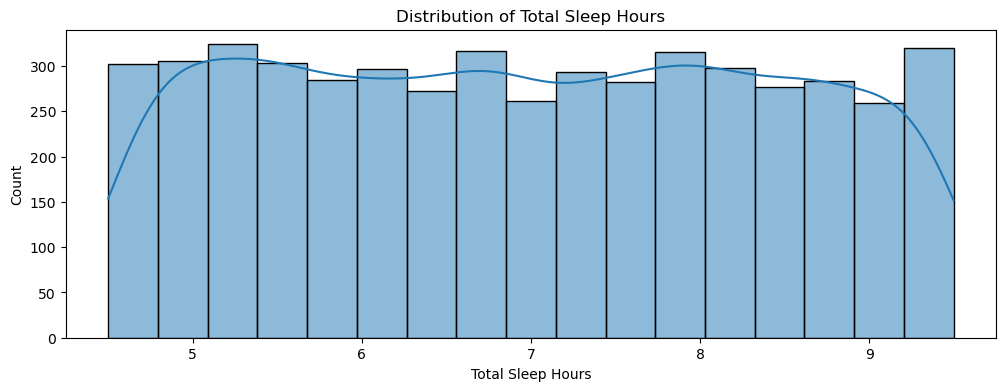

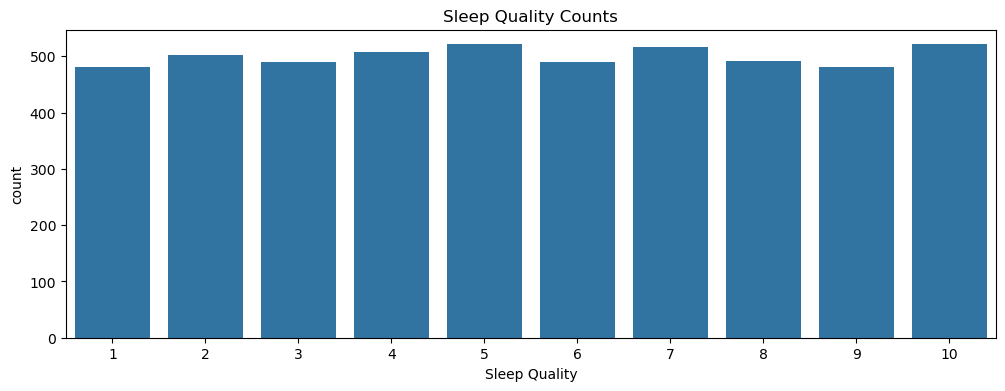

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2.1 Load dataset
df = pd.read_csv('sleep_cycle_productivity.csv')

# 2.2 Quick overview
print(df.shape)
df.head()

# 2.3 Data summary
df.describe(include='all')

# 2.4 Check missing values
df.isna().mean().round(3)

# 2.5 Visualize distributions of key features
plt.figure(figsize=(12,4))
sns.histplot(df['Total Sleep Hours'], kde=True)
plt.title('Distribution of Total Sleep Hours')
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(x='Sleep Quality', data=df)
plt.title('Sleep Quality Counts')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 3.1.1 Drop rows with missing target
df = df.dropna(subset=['Sleep Quality'])

# 3.1.2 Impute or drop other missing
df = df.dropna()  # or consider imputing

# 3.1.3 Convert categorical to numeric
le = LabelEncoder()
df['Gender_enc'] = le.fit_transform(df['Gender'])

# 3.1.4 Feature engineering: compute sleep duration if needed
# Assuming Total Sleep Hours is reliable, skip.

# 3.1.5 Define features & target
X = df[['Age', 'Total Sleep Hours', 'Exercise (mins/day)', 'Caffeine Intake (mg)',
        'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)', 
        'Productivity Score', 'Mood Score', 'Stress Level', 'Gender_enc']]
y_cont = df['Sleep Quality']            # for regression/MAE
y_bin = (df['Sleep Quality'] >= 6).astype(int)  # “good” (6–10) vs “poor” (1–5)

# 3.1.6 Train/test split
X_train, X_test, y_train_bin, y_test_bin, y_train_cont, y_test_cont = train_test_split(
    X, y_bin, y_cont, test_size=0.2, random_state=42)

# 3.1.7 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


RF best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
LR1 best params: {'lr__C': 0.1}
LR2 best params: {'lr__C': 0.1}
LR3 best params: {'lr__C': 0.1, 'lr__l1_ratio': 0.1}
LR1: Accuracy = 0.495, F1 = 0.456
LR2: Accuracy = 0.484, F1 = 0.498
LR3: Accuracy = 0.491, F1 = 0.449
K-Means inertias: {2: 36971.903908864224, 3: 34998.640173909414, 4: 33580.960922538485, 5: 32346.56504970856}


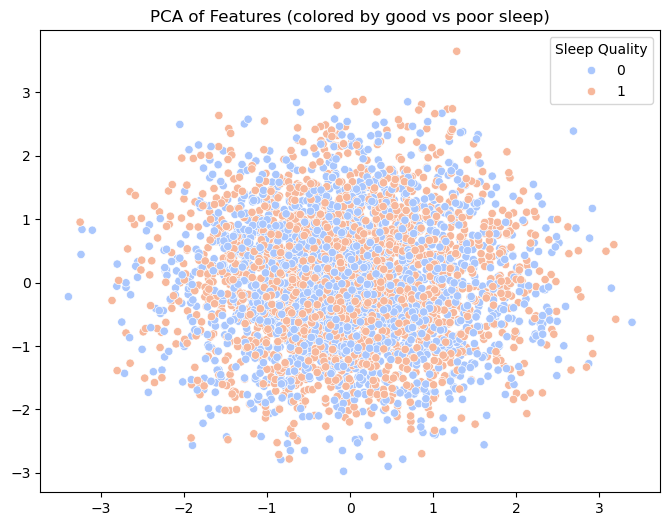

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline

# 3.2.1 Random Forest (binary classification)
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train_bin)
best_rf = rf_grid.best_estimator_
print("RF best params:", rf_grid.best_params_)

# --- Model LR1: Basic L2 Logistic Regression ---
pipe_lr1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', solver='liblinear', random_state=42))
])
params_lr1 = {
    'lr__C': [0.01, 0.1, 1, 10]
}
grid_lr1 = GridSearchCV(pipe_lr1, params_lr1, cv=3, scoring='f1', n_jobs=-1)
grid_lr1.fit(X_train, y_train_bin)
print("LR1 best params:", grid_lr1.best_params_)

# --- Model LR2: Class-Weighted Logistic Regression ---
pipe_lr2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', solver='liblinear',
                              class_weight='balanced', random_state=42))
])
params_lr2 = {
    'lr__C': [0.01, 0.1, 1, 10]
}
grid_lr2 = GridSearchCV(pipe_lr2, params_lr2, cv=3, scoring='f1', n_jobs=-1)
grid_lr2.fit(X_train, y_train_bin)
print("LR2 best params:", grid_lr2.best_params_)

# --- Model LR3: Elastic-Net Logistic Regression ---
pipe_lr3 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga',
                              max_iter=5000, random_state=42))
])
params_lr3 = {
    'lr__C':      [0.01, 0.1, 1, 10],
    'lr__l1_ratio': [0.1, 0.5, 0.9]
}
grid_lr3 = GridSearchCV(pipe_lr3, params_lr3, cv=3, scoring='f1', n_jobs=-1)
grid_lr3.fit(X_train, y_train_bin)
print("LR3 best params:", grid_lr3.best_params_)

# --- Compare on Test Set ---
for name, grid in [('LR1', grid_lr1), ('LR2', grid_lr2), ('LR3', grid_lr3)]:
    y_pred = grid.predict(X_test)
    print(f"{name}: Accuracy = {accuracy_score(y_test_bin, y_pred):.3f}, "
          f"F1 = {f1_score(y_test_bin, y_pred):.3f}")

# 3.2.3 K-Means Clustering (unsupervised)
# Try k=2..5 to discover patterns
inertias = {}
for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_scaled)
    inertias[k] = km.inertia_
print("K-Means inertias:", inertias)

# 3.2.4 PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train_bin, palette='coolwarm')
plt.title('PCA of Features (colored by good vs poor sleep)')
plt.show()


In [18]:
# 4.1 Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test_scaled)
print("RF Accuracy:", accuracy_score(y_test_bin, y_pred_rf))
print("RF F1 Score:", f1_score(y_test_bin, y_pred_rf).round(3))
print("RF Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_rf))

# 4.2 Evaluate Logistic Regression
y_pred_lr = best_lr.predict(X_test_scaled)
print("LR Accuracy:", accuracy_score(y_test_bin, y_pred_lr))
print("LR F1 Score:", f1_score(y_test_bin, y_pred_lr).round(3))
print("LR Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_lr))

# 4.3 (Optional) Regression MAE on continuous target
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42, **rf_grid.best_params_)
rfr.fit(X_train_scaled, y_train_cont)
y_pred_rfr = rfr.predict(X_test_scaled)
print("RF Regression MAE:", mean_absolute_error(y_test_cont, y_pred_rfr).round(3))


RF Accuracy: 0.492
RF F1 Score: 0.483
RF Confusion Matrix:
 [[255 226]
 [282 237]]
LR Accuracy: 0.495
LR F1 Score: 0.456
LR Confusion Matrix:
 [[283 198]
 [307 212]]
RF Regression MAE: 2.502
